4/4 [==============================] - 0s 15ms/step
0 [D loss: 0.6170 | D acc: 49.61%] [G loss: 0.5822]
1/1 [==============================] - 0s 174ms/step


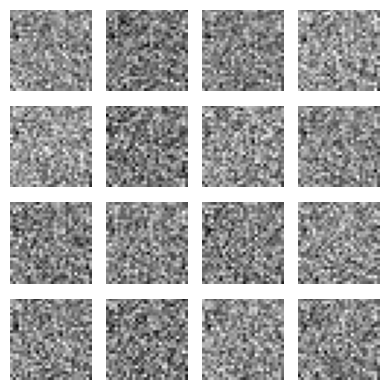

4/4 [==============================] - 0s 11ms/step
GAN Training Complete!


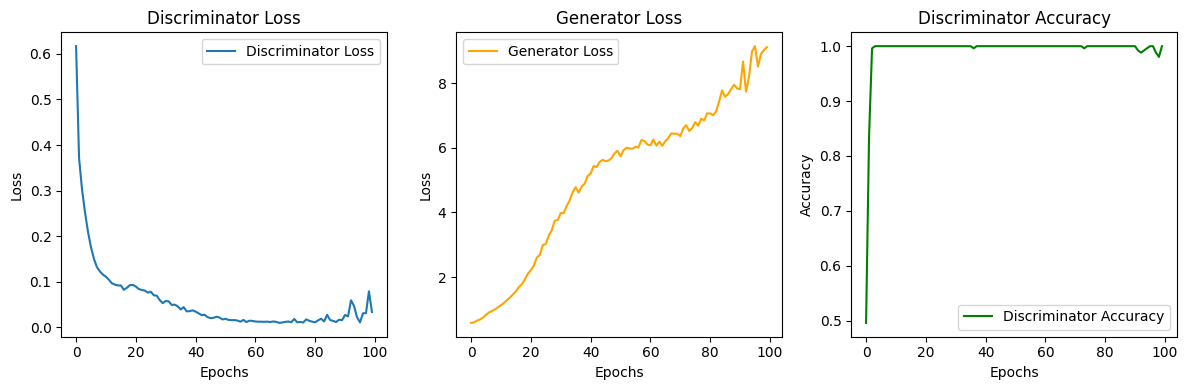

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

# Load and preprocess the MNIST dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)

# Hyperparameters
latent_dim = 100
batch_size = 128
epochs = 100
sample_interval = 1000

# Create output directory for generated images
os.makedirs("generated_images", exist_ok=True)

# Build the Generator
def build_generator():
    model = keras.Sequential([
        keras.layers.Dense(256, activation="relu", input_dim=latent_dim),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(28 * 28 * 1, activation="tanh"),
        keras.layers.Reshape((28, 28, 1))
    ])
    return model

# Build the Discriminator
def build_discriminator():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

# Instantiate models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.0002, 0.5), metrics=["accuracy"])

# Combine into GAN
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.0002, 0.5))

# Lists to store training metrics
d_losses = []
d_accuracies = []
g_losses = []

# Function to save generated images
def save_generated_images(epoch, show=True, save=True):
    noise = np.random.normal(0, 1, (16, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Scale from [-1,1] to [0,1]

    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    count = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap="gray")
            axs[i, j].axis("off")
            count += 1
    fig.tight_layout()
    
    if save:
        plt.savefig(f"generated_images/mnist_{epoch}.png")
    
    if show:
        plt.show()
    else:
        plt.close()


# Training Loop
for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Store losses and accuracy
    d_losses.append(d_loss[0])
    d_accuracies.append(d_loss[1])
    g_losses.append(g_loss)

    # Print progress
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f} | D acc: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
        save_generated_images(epoch)

print("GAN Training Complete!")

# Plot losses and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(g_losses, label="Generator Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label="Discriminator Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


